## GLANCE: Global Actions In A Nutshell for Counterfactual Explainability

**GLANCE** is a versatile and adaptive framework for generating global counterfactual explanations. These explanations are expressed as actions that offer recourse to large population subgroups. The framework aims to provide succinct explanations and insights, balancing the trade-offs between maximizing effectiveness, minimizing cost, and keeping the number of actions small and interpretable.

The main challenge lies in carefully balancing these trade-offs to ensure the generated actions are both effective and cost-efficient, while remaining easy to understand. This is achieved through the use of two algorithms:

- **C-GLANCE**
- **T-GLANCE**

These algorithms allow for flexible adjustment of the trade-offs between the three key objectives: **effectiveness**, **cost**, and **size**. The size objective can be fine-tuned as a parameter to ensure the actions are few and simple to interpret.

In this notebook, we will explore how to use these algorithms effectively.

We will use the COMPAS Dataset from the ProPublica Analysis ([reference](https://github.com/propublica/compas-analysis))

## Preliminaries

### Import Dependencies 
As usual in python, the first step is to import all necessary packages.



In [1]:
from xgboost import XGBClassifier
import pandas as pd
from aix360.algorithms.glance.iterative_merges.iterative_merges import IterativeMerges
from aix360.algorithms.glance.counterfactual_tree.counterfactual_tree import CounterfactualTree
from aix360.datasets.compas_dataset import COMPASDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Load Dataset


In [2]:
data = COMPASDataset()
df = data.dataframe()
df.head()

Using Compas dataset:  c:\users\nikolastheol\documents\github\aix360\aix360\datasets\..\data\compas_data\compas.csv


,Sex,Age_Cat,Race,C_Charge_Degree,Priors_Count,Time_Served,Status
0,Male,Greater than 45,Other,F,0,0,0
1,Male,25 - 45,African-American,F,0,10,1
2,Male,Less than 25,African-American,F,4,1,1
3,Male,25 - 45,Other,M,0,1,0
4,Male,25 - 45,Caucasian,F,14,6,1


## Example Model to be used for explanations
We use the train set to train a simple XGBoostClassifier. This will serve as the demonstrative model, which we will then treat as a black box and apply our algorithm.

Of course, any model can be used in its place. Our purpose here is not to produce a good model, but to audit the fairness of an existing one.



In [3]:
X = df.drop(columns='Status')
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13)
num_features = X_train._get_numeric_data().columns.to_list()
cate_features = X_train.columns.difference(num_features)

In [4]:
model = XGBClassifier()
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            cate_features,
        )
    ],
    remainder="passthrough",
)
_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", model),
    ]
)
_model.fit(X_train,y_train)
predictions = _model.predict(X_test)

affected = X_test[predictions == 0].reset_index(drop=True)
unaffected = X_test[predictions == 1].reset_index(drop=True)
train_dataset = X_train.copy()


for col in num_features:
    train_dataset[col] = train_dataset[col].astype(float)

    
train_dataset["target"] = y_train
feat_to_vary = list(affected.columns)
#feat_to_vary.remove('Time_Served')
target_name = "Status"

## A Practical Example of GLANCE

### C-GLANCE (Iterative Merges)

In [5]:
# load C-GLANCE framework with:
# - the model to be explained
# - number of initial clusters
# - number of final clusters, e.g the number of actions to be generated at the end of the algorithm
# - number of local counterfactuals, in order to generate candidate counterfactual explanations

global_method = IterativeMerges(
    _model,
    initial_clusters=100,
    final_clusters=3,
    num_local_counterfactuals=10,
)
global_method.fit(
    df.drop(columns=["Status"]),
    df["Status"],
    train_dataset,
    feat_to_vary,
    cf_generator="Dice"
)

In [6]:
clusters, clusters_res = global_method.explain_group(affected)

100%|██████████| 490/490 [00:15<00:00, 31.15it/s]
c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:854: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, value in row['action'].to_frame().T.reset_index(drop=True).iteritems():


Action 1 
Priors_Count +12.0 
Time_Served +191.60000000000002 

Effectiveness: 100.00%	Cost: 5.55


Action 2 
Priors_Count +8.4 

Effectiveness: 100.00%	Cost: 2.11


Action 3 
Age_Cat = Less than 25 
Time_Served +410.2 

Effectiveness: 100.00%	Cost: 6.10


TOTAL EFFECTIVENESS: 100.00%
TOTAL COST: 3.06


## C-GLANCE using RandomSampling as counterfactual generation method
Our framework  is not tied to a specific counterfactual generation technique. 
In order to demonstrate its modularity, we developed different methods for generating candidate counterfactual explanations, such as:
- NearestNeighbors
- RandomSampling

In order to use them, the user should provide to the **fit** method with the **cf_generator** variable and choose the method of his/hers liking.

In [10]:
global_method = IterativeMerges(
    _model, initial_clusters=100, final_clusters=3, num_local_counterfactuals=10
)
global_method.fit(
    df.drop(columns=["Status"]),
    df["Status"],
    train_dataset,
    feat_to_vary,
    cf_generator="RandomSampling",
)

In [11]:
clusters, clusters_res = global_method.explain_group(affected)

100%|██████████| 470/470 [00:13<00:00, 33.90it/s]
c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:852: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, value in row['action'].to_frame().T.reset_index(drop=True).iteritems():


Action 1 
Age_Cat = Less than 25 
Time_Served +338.36531724140815 

Effectiveness: 100.00%	Cost: 5.09


Action 2 
Age_Cat = 25 - 45 
Time_Served +368.4070870825314 

Effectiveness: 100.00%	Cost: 5.11


Action 3 
Age_Cat = Less than 25 
Time_Served +396.107539558512 

Effectiveness: 100.00%	Cost: 5.80


TOTAL EFFECTIVENESS: 100.00%
TOTAL COST: 4.72


# T-GLANCE

In [12]:
global_method_args_fit = {}
global_method_args_fit["train_dataset"] = train_dataset

In [13]:
cf_tree = CounterfactualTree(_model)
cf_tree.fit(X, y, train_dataset)

In [ ]:
node = cf_tree.partition_group(affected)

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


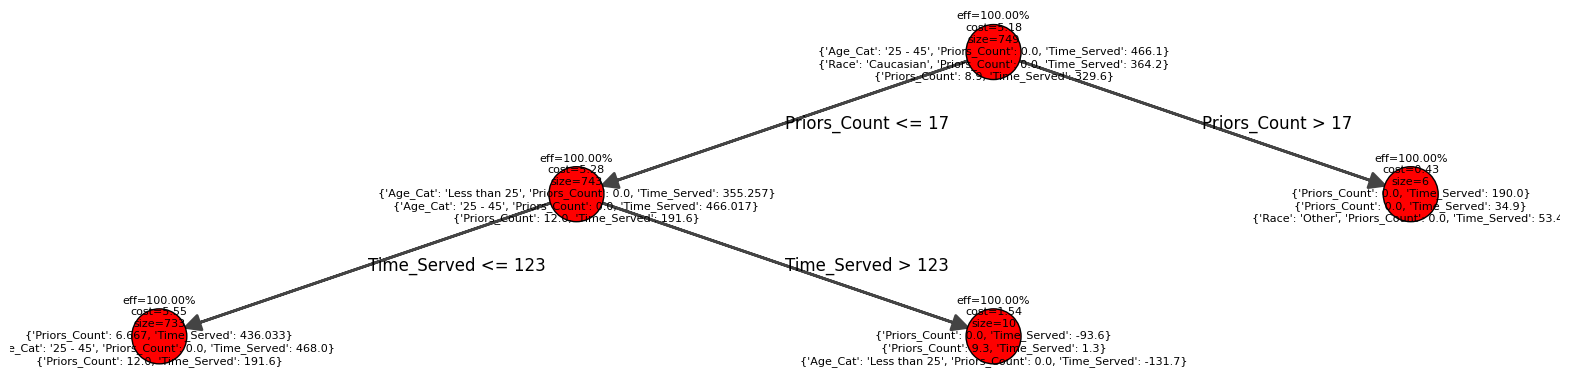

In [14]:
node.display_igraph_jupyter(
    numeric_features=affected.select_dtypes(
        include=["number"]).columns.tolist()
)

In [15]:
cf_tree.cumulative_leaf_actions()


TOTAL EFFECTIVENESS: 100.00%

TOTAL COST: 1.19


(749, 894.0585600421578, 9)